In [2]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils, util
import CCores.cores as cores
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from scipy.ndimage.measurements import label

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
from utils import u_grid, u_interpolate as u_int
import glob

met_folder = '/media/ck/Elements/Africa/WestAfrica/NFLICS/MCS_TIR/real_time_data/2020/09/06/'

files = glob.glob(met_folder + 'IR_108_BT_20200906_0000.nc')

ds = xr.open_dataset(files[0], decode_times=False)

In [84]:
files

['/media/ck/Elements/Africa/WestAfrica/NFLICS/MCS_TIR/real_time_data/2020/09/06/IR_108_BT_20200906_0000.nc']

In [85]:
data_resolution = 5 # in km
# make salem grid
grid5k = u_grid.make(np.arange(-19,0), np.arange(4,20), data_resolution*1000)
dlon = ds['lon_2d'].squeeze().values.T
dlat = ds['lat_2d'].squeeze().values.T
inds, weights, shape = u_int.interpolation_weights_grid(dlon, dlat, grid5k)

data = ds['IR108_BT'].squeeze().values.T
try:
    orig5k = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lon5k, lat5k = grid5k.ll_coordinates

ff = os.path.basename(files[0])
year = ff[10:14]
month = ff[14:16]
day = ff[16:18]
hour = ff[19:21]
minute = ff[21:23]


date = [datetime(int(year), int(month), int(day), int(hour), int(minute))]

In [5]:
data_resolution = 3 # in km
# make salem grid
grid3k = u_grid.make(np.arange(-19,0), np.arange(4,20), data_resolution*1000)
dlon = ds['lon_2d'].squeeze().values.T
dlat = ds['lat_2d'].squeeze().values.T
inds, weights, shape = u_int.interpolation_weights_grid(dlon, dlat, grid3k)

data = ds['IR108_BT'].squeeze().values.T
try:
    orig3k = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lon3k, lat3k = grid3k.ll_coordinates

ff = os.path.basename(files[0])
year = ff[10:14]
month = ff[14:16]
day = ff[16:18]
hour = ff[19:21]
minute = ff[21:23]


date = [datetime(int(year), int(month), int(day), int(hour), int(minute))]

In [87]:
regrid3k = grid3k.to_dataset()

In [88]:
regrid5k = grid5k.to_dataset()

In [89]:
outt, nogood, t_thresh_size, t_thresh_cut, pix_nb, area_img = powerBlob_utils.filter_img(orig5k, 5)
wav = util.waveletT(outt, dataset='METEOSAT5K_vera')
power_msg = powerBlob_utils.find_scales_dominant(wav, nogood, area_img, dataset='MSG')

outmin -87.36108862240472 24.212036132812504


In [90]:
old_nflics5k = xr.DataArray(power_msg, coords=[lat5k[:,0], lon5k[0,:]], dims=['lat', 'lon'])

In [91]:
old_nflics5k.name = 'power'

In [92]:
power_msg3k = regrid3k.salem.transform(old_nflics5k)

In [93]:
old_nflics3k = xr.DataArray(power_msg3k, coords=[lat3k[:,0], lon3k[0,:]], dims=['lat', 'lon'])

In [94]:
old_nflics3k.name = 'power'

In [151]:
wObj = cores.dataset('METEOSAT5K_vera')
wObj.read_img(orig5k, lon5k, lat5k, edge_smoothing=True)
wObj.applyWavelet()

Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -87.36108862240472 24.212036132812504


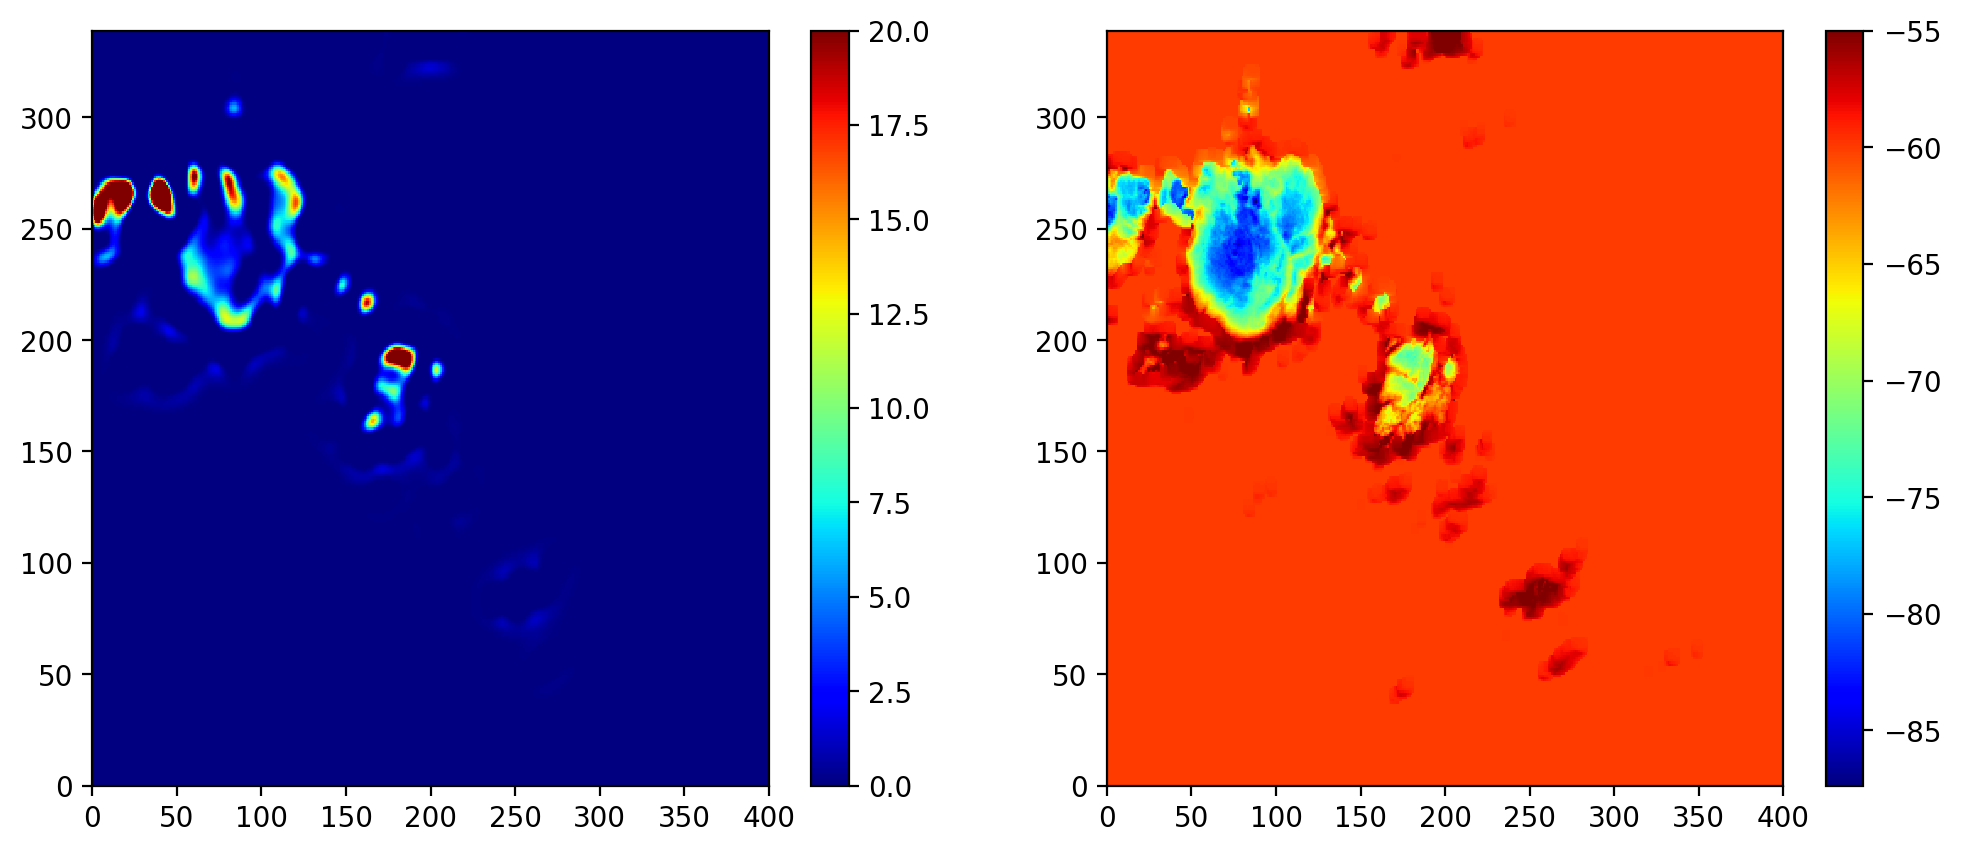

In [152]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(121)
plt.pcolormesh(wObj.power[2,:,:], vmax=20, cmap='jet')
plt.colorbar()
ax = f.add_subplot(122)
plt.pcolormesh(wObj.image, cmap='jet',vmax=-55)
plt.colorbar()

In [155]:
v5knflics = wObj.scaleWeighting(wtype='nflics', data_tag='MSG')

/home/ck/miniconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2943: RuntimeWarning: overflow encountered in short_scalars
  elif vmax - vmin <= maxabsvalue * tiny:


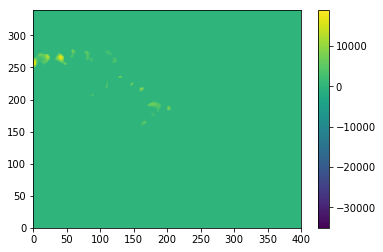

Saved /home/ck/DIR/cornkle/MCSfiles/MSG_cores/text.nc


In [170]:
ss = wObj.to_dataarray(filepath ='/home/ck/DIR/cornkle/MCSfiles/MSG_cores/text.nc')

In [165]:
print(ss)

None


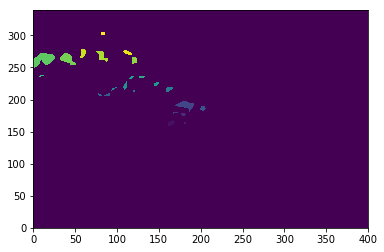

In [180]:
v5knflicsv2 = wObj.scaleWeighting(wtype='nflicsv2')

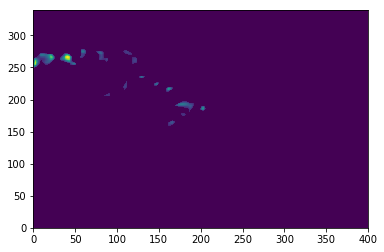

In [162]:
plt.pcolormesh(v5knflicsv2, vmin=0)

In [ ]:
wObj.to

In [99]:
wObj.scales

array([25.        , 35.35533906, 50.        ])

In [12]:
wObj2 = cores.dataset('METEOSAT3K_veraLS')
wObj2.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
wObj2.applyWavelet()
v3knflicsv2 = wObj2.scaleWeighting(wtype='nflicsv2')#', data_tag='MSG')

Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021]
outmin -87.6425906327473 24.2120361328125


In [13]:
ss = wObj2.to_dataarray(filepath ='/home/ck/DIR/cornkle/MCSfiles/MSG_cores/text.nc')

Saved /home/ck/DIR/cornkle/MCSfiles/MSG_cores/text.nc


In [8]:
out = xr.open_dataset('/home/ck/DIR/cornkle/MCSfiles/MSG_cores/text.nc')

In [9]:
v3knflicsv2 = out['power'].values

In [14]:
out

<xarray.Dataset>
Dimensions:  (lat: 566, lon: 667)
Coordinates:
  * lat      (lat) float64 4.0 4.027 4.054 4.081 ... 18.89 18.92 18.95 18.97
  * lon      (lon) float64 -19.0 -18.97 -18.95 -18.92 ... -1.106 -1.079 -1.052
Data variables:
    power    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tir      (lat, lon) int16 ...
Attributes:
    radii:              [ 1  2  2  4  5  7 11 15 21]
    scales_rounded:     [  9  13  18  24  34  48  66  92 129]
    scales_original:    [  9.          12.552693    17.50778905  24.41887789 ...
    cutout_T:           -40
    cutout_minPixelNb:  28.274333882308138
    scaling_factor:     100

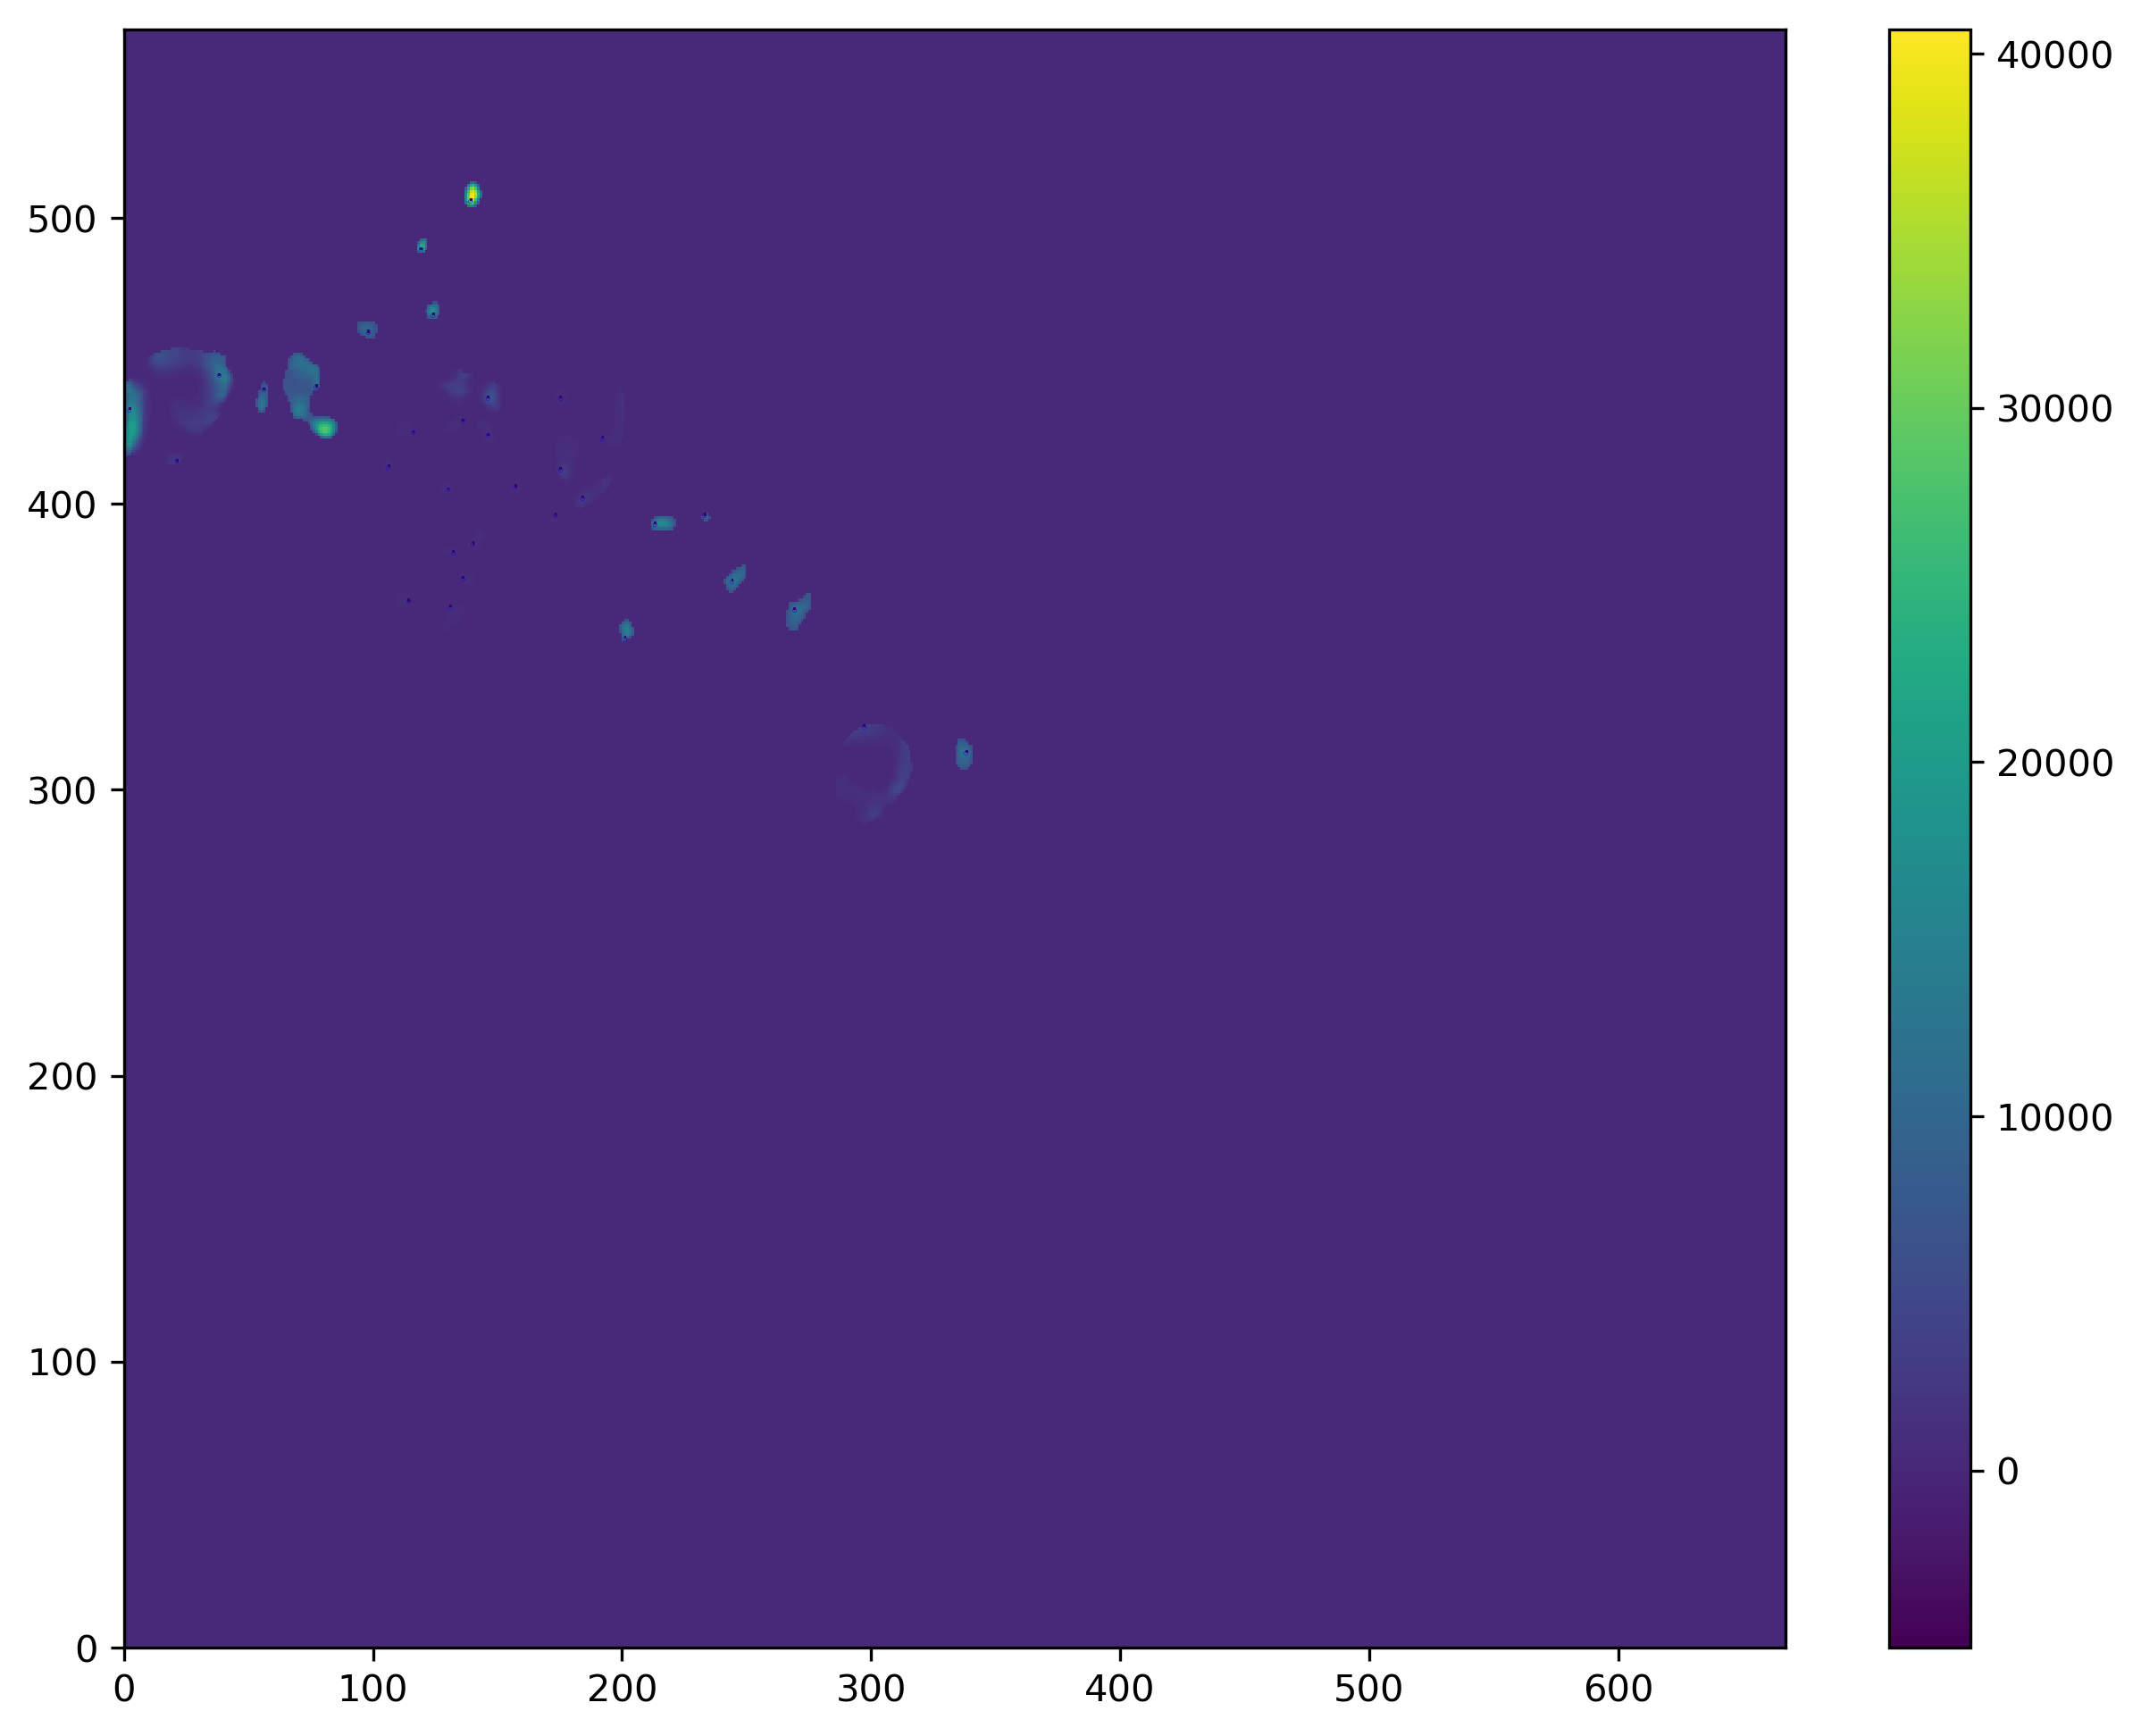

In [11]:
f = plt.figure(figsize=(10,8), dpi=300)
ax = f.add_subplot(111)
plt.pcolormesh((np.round(v3knflicsv2,2)*100).astype(int), vmin=-5000)
pos = np.where(v3knflicsv2<-1)
for y,x in zip(pos[0], pos[1]):
    plt.plot(x,y, 'bo', markersize=0.1)
plt.colorbar()

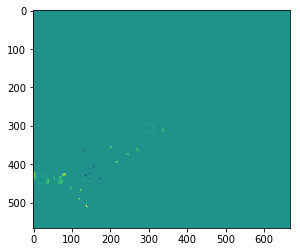

In [229]:
plt.imshow(v3knflicsv2)

In [240]:
labels, numL = label((v3knflicsv2!=0).astype(int))
u, cnt = np.unique(labels, return_counts=True)

for inds, c in zip(u, cnt):
    print(inds, np.sum(v3knflicsv2[labels==inds]<0))

0 0
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 11


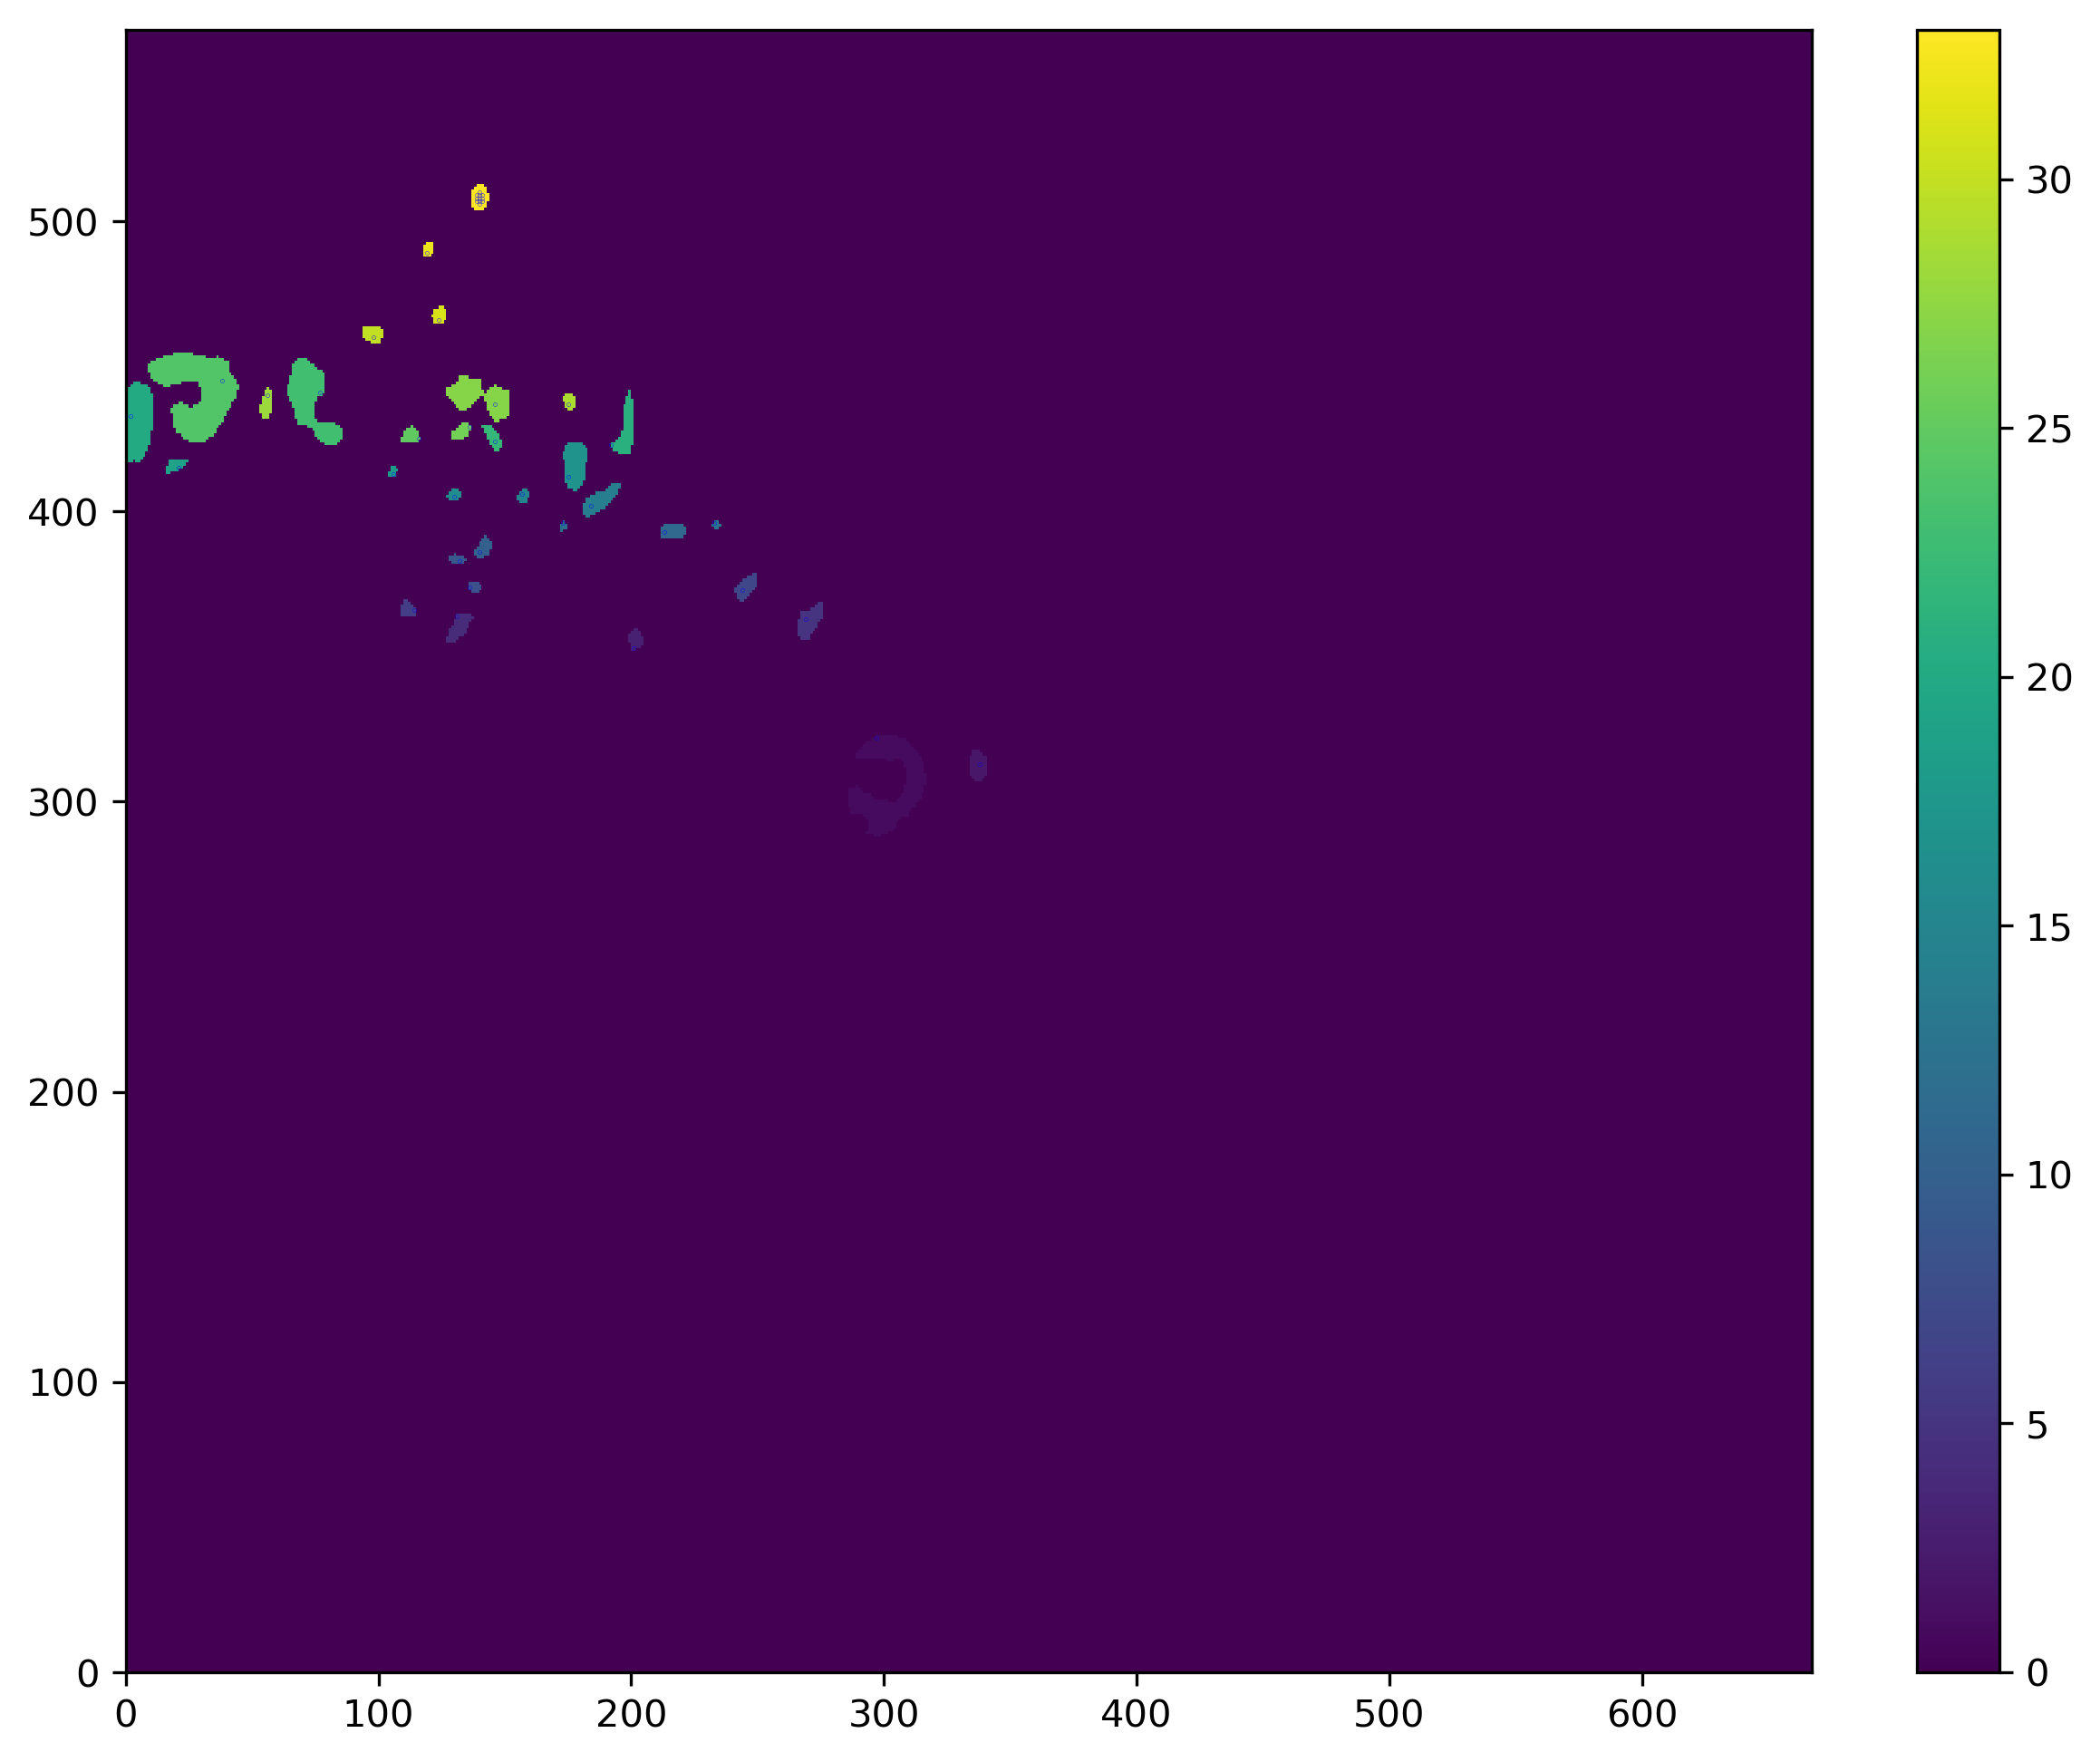

In [231]:
f = plt.figure(figsize=(10,8), dpi=300)
ax = f.add_subplot(111)
plt.pcolormesh(labels)
pos = np.where(v3knflicsv2<-1)
for y,x in zip(pos[0], pos[1]):
    plt.plot(x,y, 'bo', markersize=0.1)
plt.colorbar()

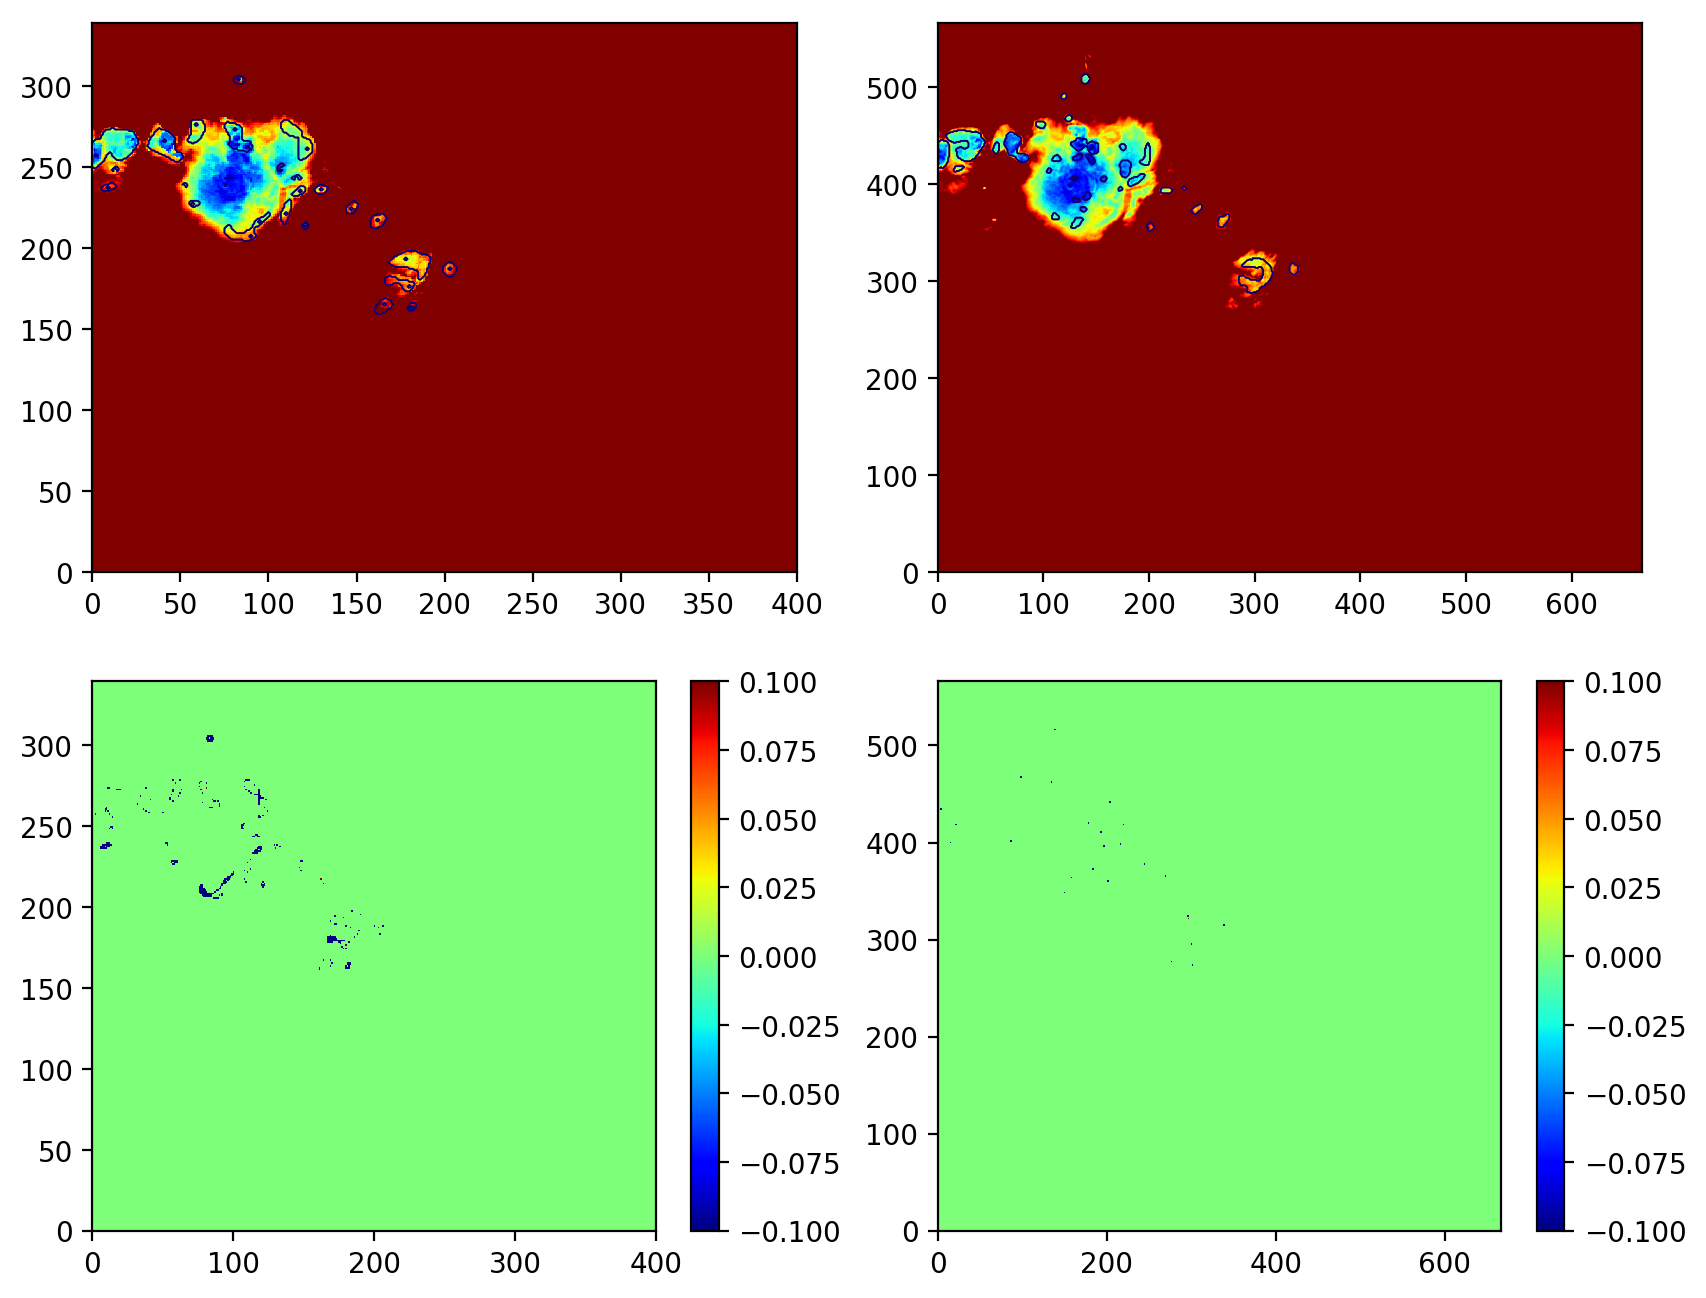

In [187]:
f = plt.figure(figsize=(10,8), dpi=200)
ax = f.add_subplot(221)

plt.pcolormesh(wObj.image, vmax=-65, vmin=-85, cmap='jet')
plt.contour(v5knflics, levels=[0,1], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(222)
plt.pcolormesh(wObj2.image, vmax=-65, vmin=-85, cmap='jet')
plt.contour(v3knflicsv2, levels=[0,1], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(223)
plt.pcolormesh(np.array(v5knflicsv2>0).astype(int)-np.array(v5knflics>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

plt.colorbar()
ax = f.add_subplot(224)
plt.pcolormesh(np.array(v3knflicsv2<0).astype(int)-np.array(old_nflics3k<0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

In [177]:
wObj3 = cores.dataset('METEOSAT3K_veraLS')
wObj3.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
wObj3.applyWavelet()
v3kdominant = wObj3.scaleWeighting(wtype='dominant')#', data_tag='MSG')

Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021]
outmin -87.6425906327473 24.2120361328125
9.0
13.0
18.0
24.0
34.0
48.0
66.0
92.0
129.0


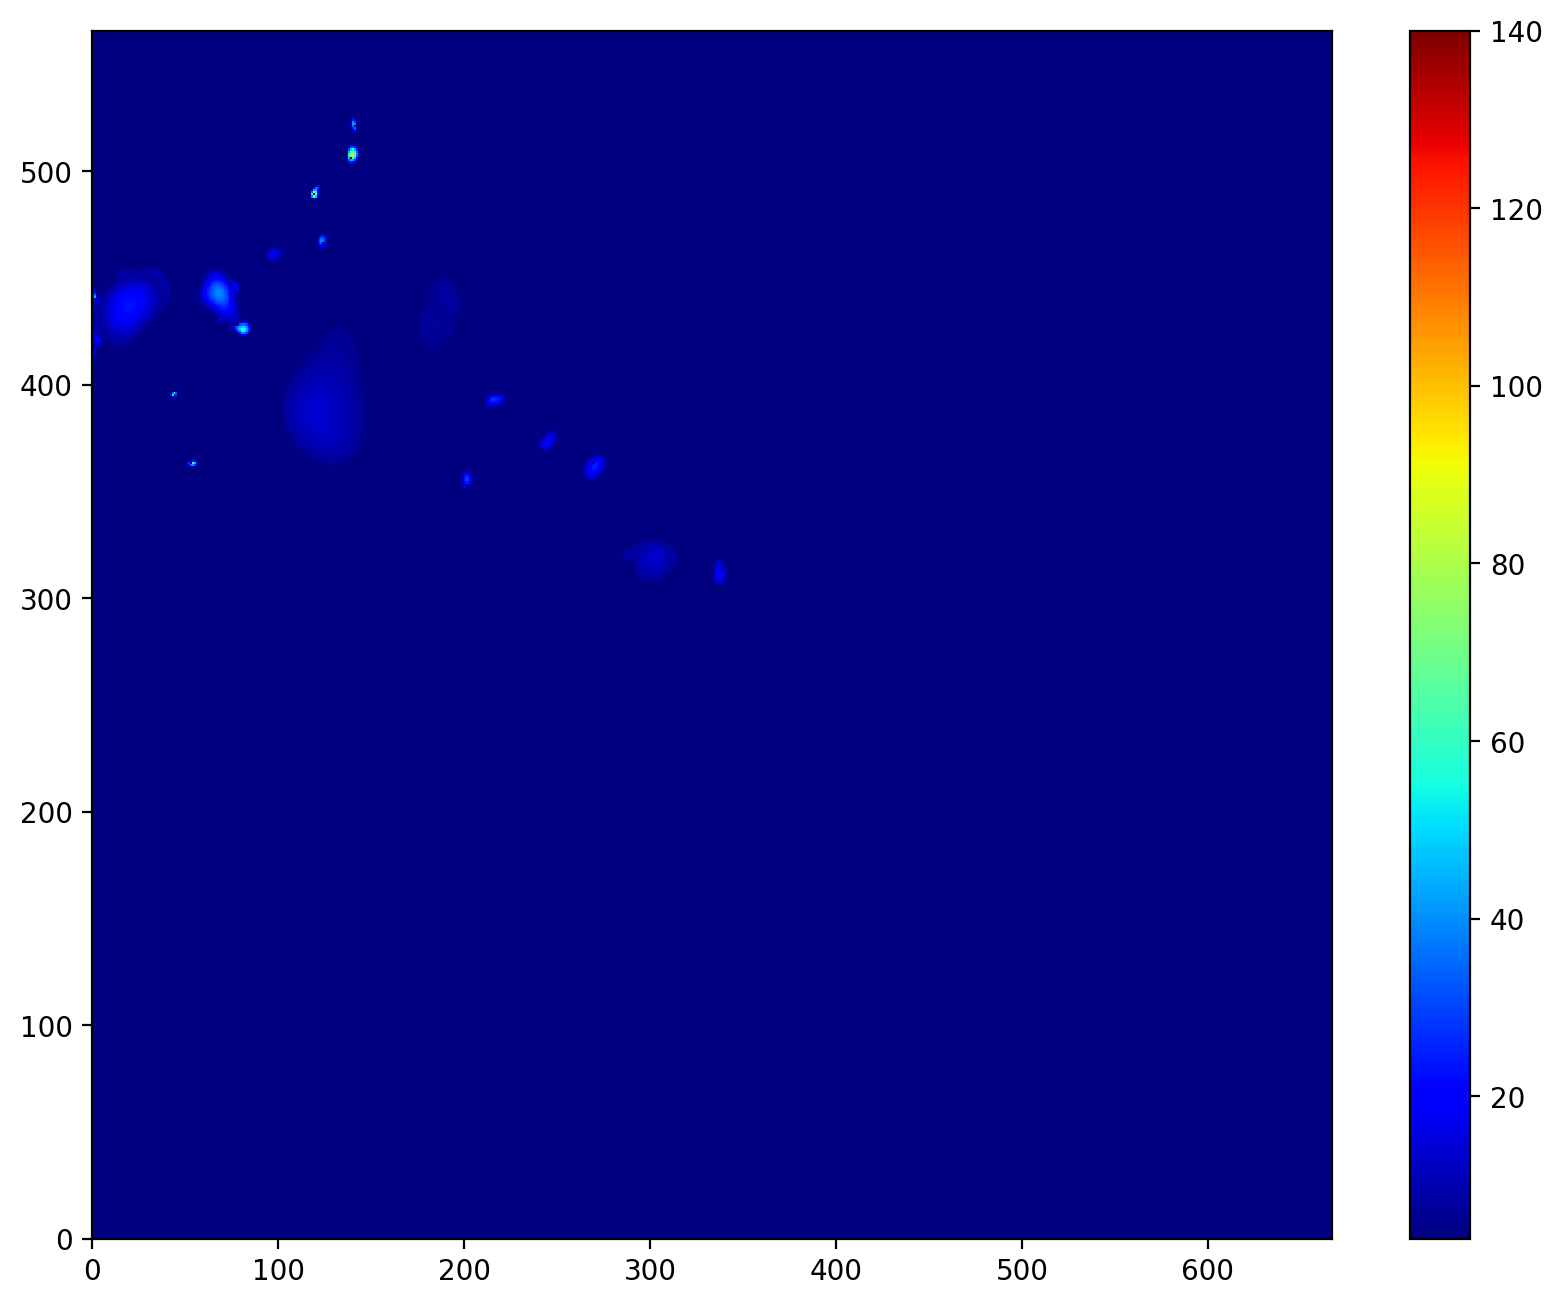

In [178]:
f = plt.figure(figsize=(10,8), dpi=200)


ax = f.add_subplot(111)

plt.pcolormesh(v3kdominant, cmap='jet', vmin=4, vmax=140)
plt.colorbar()

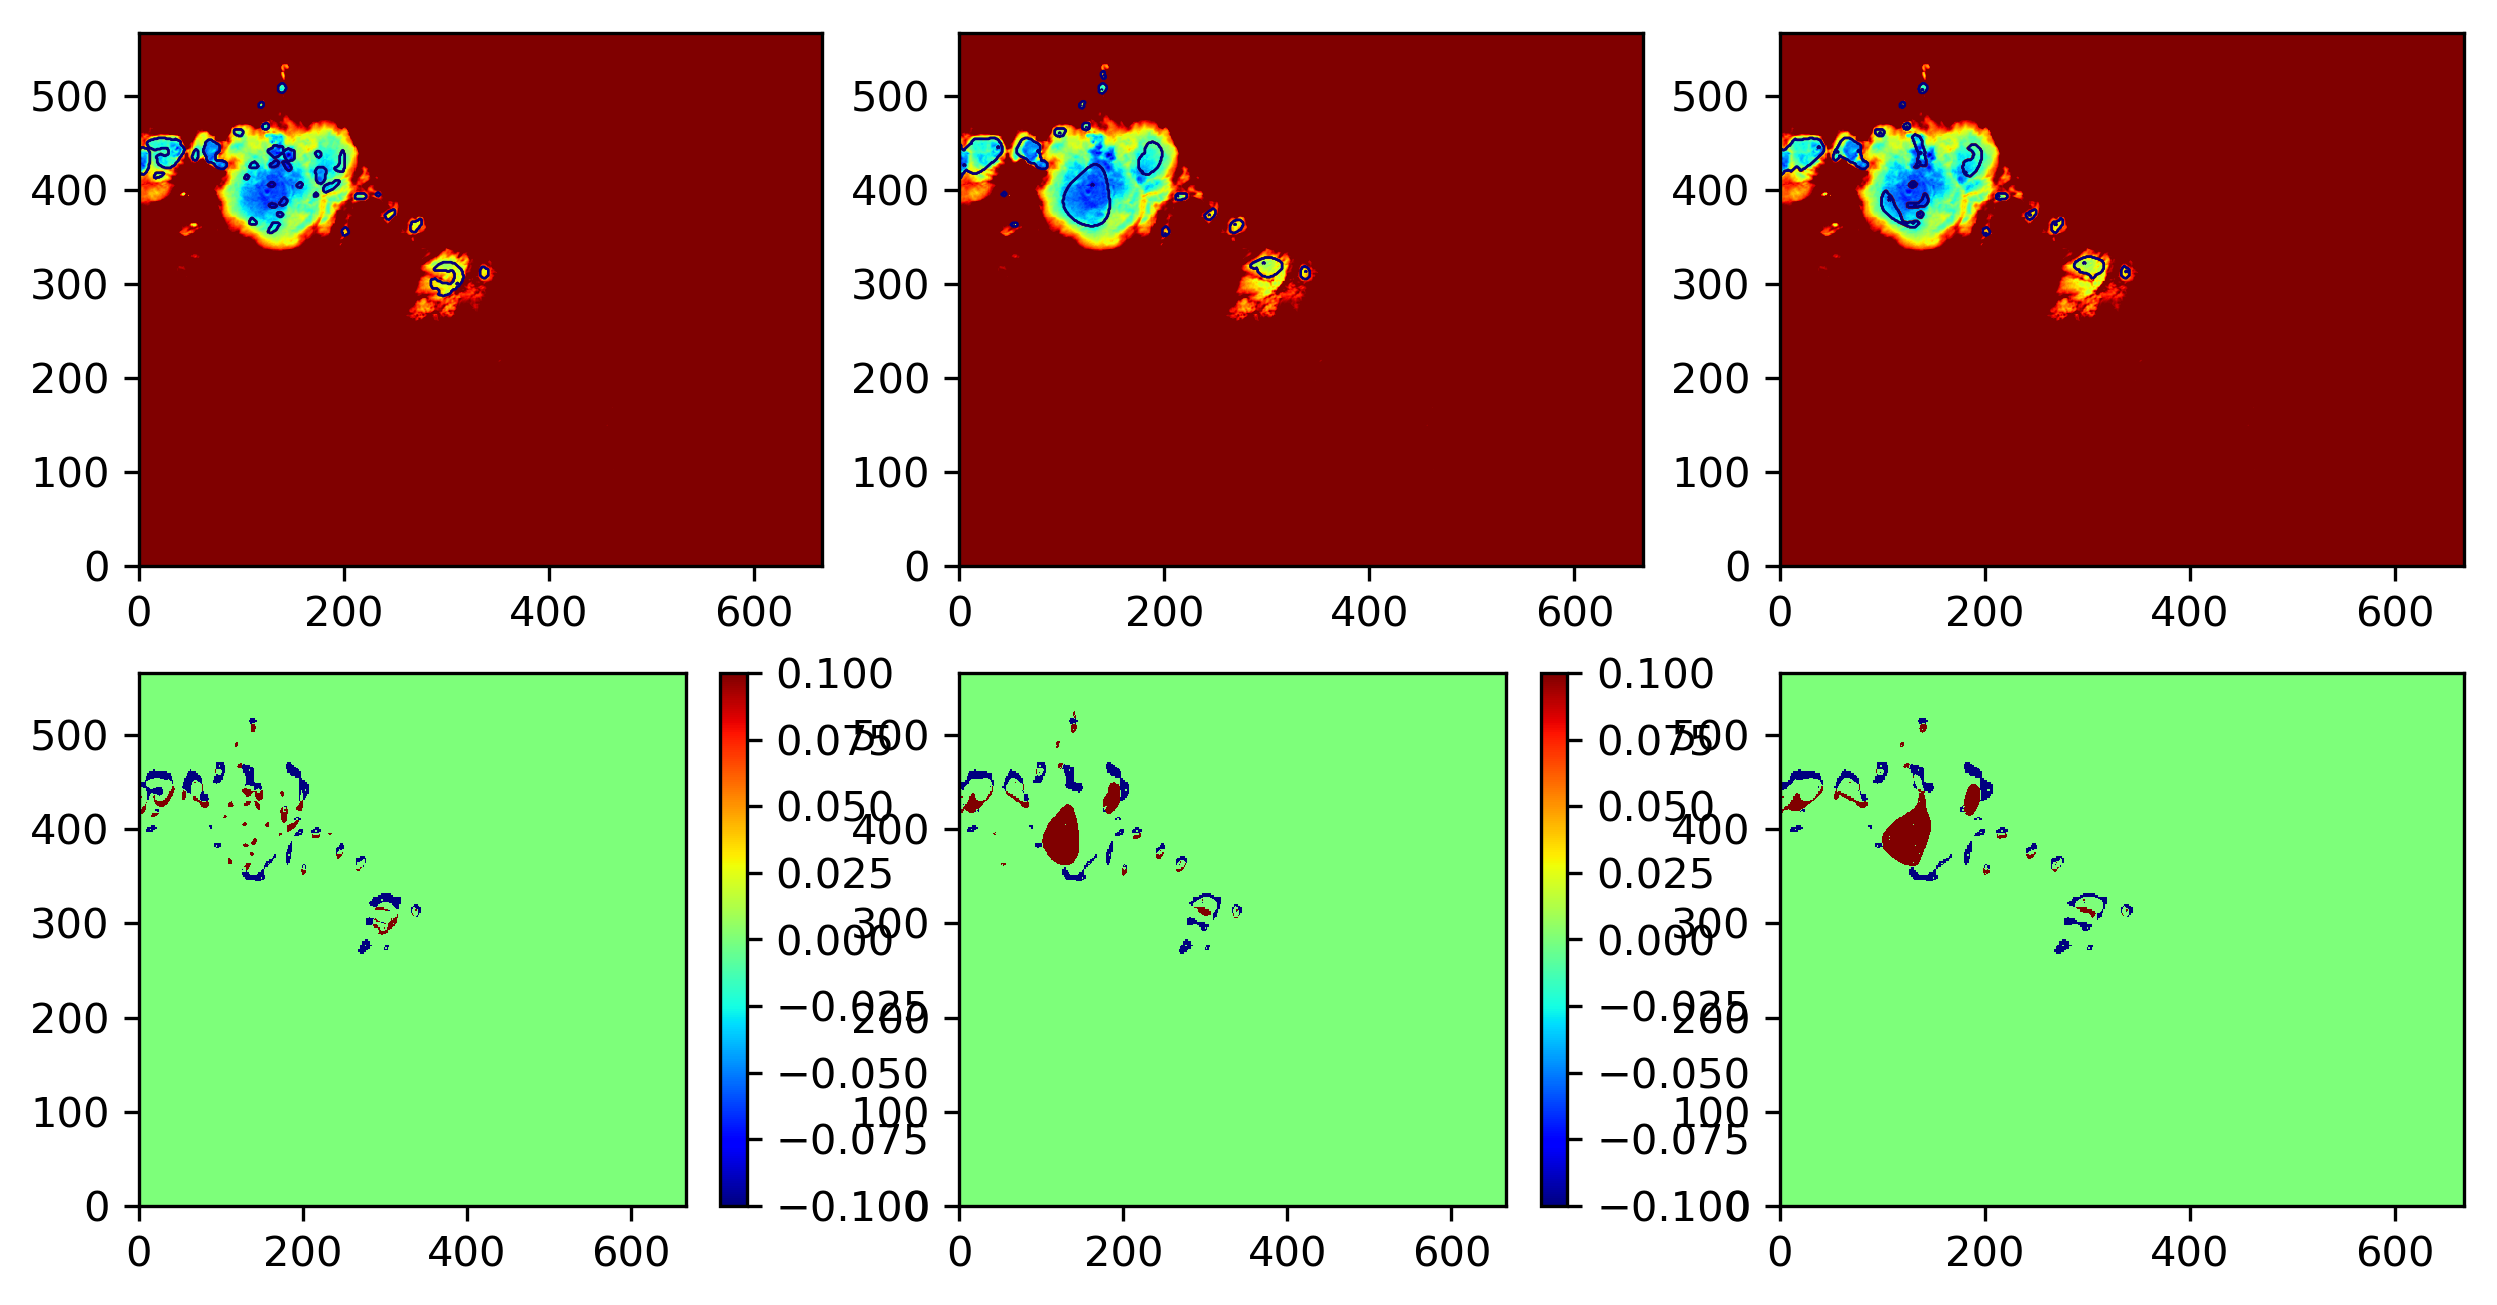

In [179]:
f = plt.figure(figsize=(10,8), dpi=300)
ax = f.add_subplot(331)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')
plt.contour(v3knflicsv2, levels=[0,1], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(332)
plt.contour(v3kdominant, levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')

ax = f.add_subplot(333)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')
plt.contour(np.sum(v3kindi[0:2,:,:], axis=0), levels=[0,1], cmap='jet_r', linewidths=0.6) #np.sum(v3kindi, axis=0)


ax = f.add_subplot(334)
plt.pcolormesh(np.array(v3knflicsv2>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

plt.colorbar()
ax = f.add_subplot(335)
plt.pcolormesh(np.array(v3kdominant>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

ax = f.add_subplot(336)
plt.pcolormesh(np.array(np.sum(v3kindi, axis=0)>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

In [134]:
wObj3 = cores.dataset('METEOSAT3K_veraLS')
wObj3.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
wObj3.applyWavelet()
v3kindi = wObj3.scaleWeighting(wtype='ind')#', data_tag='MSG')

Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
outmin -87.6425906327473 24.2120361328125


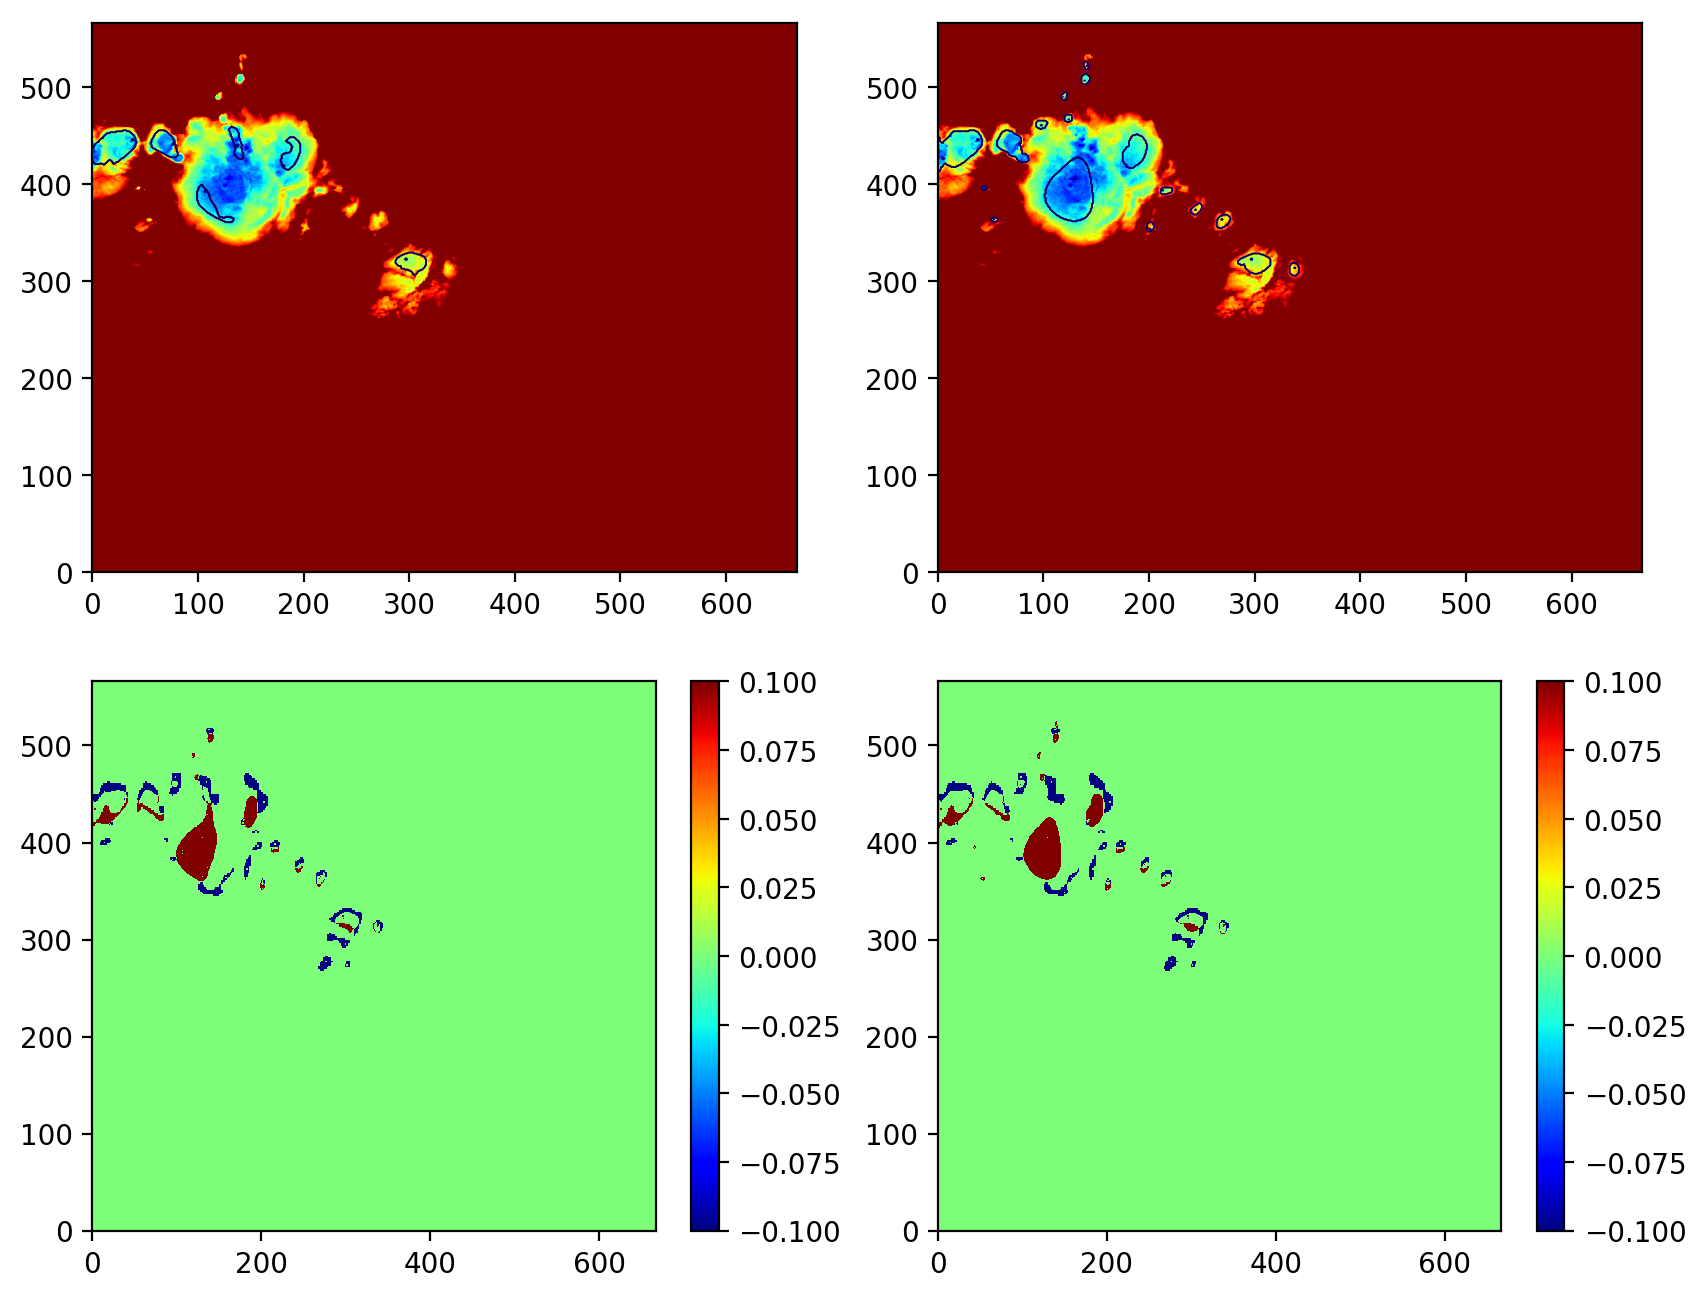

In [125]:
f = plt.figure(figsize=(10,8), dpi=200)
ax = f.add_subplot(221)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')
plt.contour(v3kindi[1,:,:], levels=[0,1], cmap='jet_r', linewidths=0.6) #np.sum(v3kindi, axis=0)

ax = f.add_subplot(222)
plt.contour(v3kdominant, levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')


ax = f.add_subplot(223)
plt.pcolormesh(np.array(np.sum(v3kindi, axis=0)>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

plt.colorbar()
ax = f.add_subplot(224)
plt.pcolormesh(np.array(v3kdominant>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

(array([1076.,  758.,  439.,  195.,  104.,   63.,   37.,   32.,   28.,
          26.]),
 array([ 1.55512556,  5.27972706,  9.00432856, 12.72893007, 16.45353157,
        20.17813307, 23.90273457, 27.62733607, 31.35193757, 35.07653908,
        38.80114058]),
 <a list of 10 Patch objects>)

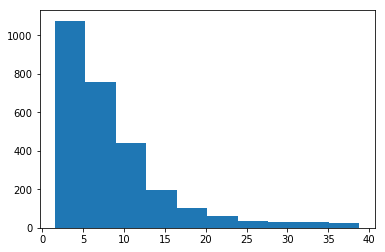

In [126]:
plt.hist(v3kindi[1,:,:][v3kindi[1,:,:]>0.1])